Ссылка на соревнование - https://www.kaggle.com/competitions/dl2025miptml/

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

### Загрузка данных и проведение первичного анализа

Проведем исследование данных в датасетах train_data и test_data.

In [6]:
train_data = pd.read_csv('fmnist_train.csv')
test_data = pd.read_csv('fmnist_test.csv')

In [8]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0,2
3,0,0,0,0,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17040 entries, 0 to 17039
Columns: 786 entries, label to Id
dtypes: float64(424), int64(362)
memory usage: 102.2 MB


In [12]:
test_data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,0,0,0,0,0,0,0,9,8,0,...,87,56,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,63,53,31,0,0,0,2
3,0,0,0,0,0,0,0,0,0,161,...,126,140,0,133,224,222,56,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, pixel1 to Id
dtypes: int64(785)
memory usage: 59.9 MB


In [16]:
print(f'train data shape: {train_data.shape} \ntest data shape: {test_data.shape}')

train data shape: (17040, 786) 
test data shape: (10000, 785)


Проверим также распределение классов с визуализацией.

label
0    1770
7    1761
3    1725
6    1704
1    1700
5    1695
9    1694
2    1677
8    1675
4    1639
Name: count, dtype: int64


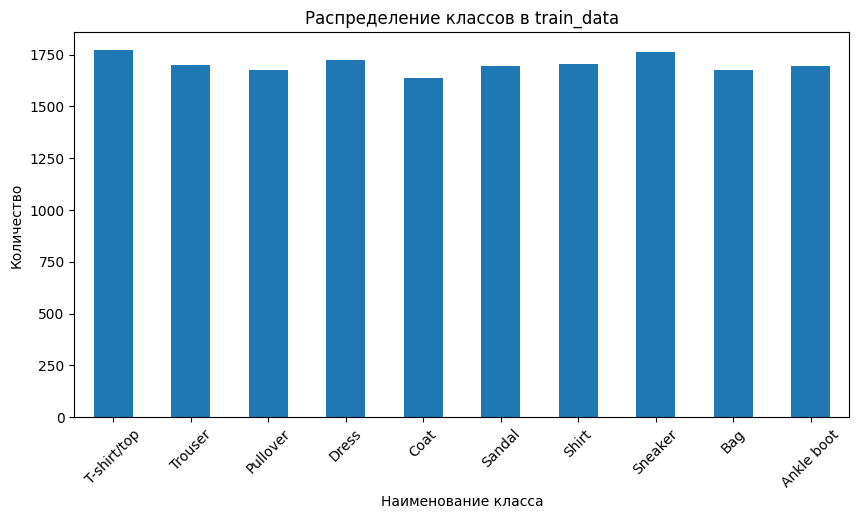

In [27]:
print(train_data['label'].value_counts())

plt.figure(figsize=(10, 5))
train_data['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Распределение классов в train_data')
plt.xlabel('Наименование класса')
plt.ylabel('Количество')
plt.xticks(ticks=np.arange(10), labels=[
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 
    'Coat', 'Sandal', 'Shirt', 'Sneaker', 
    'Bag', 'Ankle boot'], rotation=45)
plt.show()

Мы видим, что классы распределены практически равномерно. Сделаем также визуализацию классов изображений.

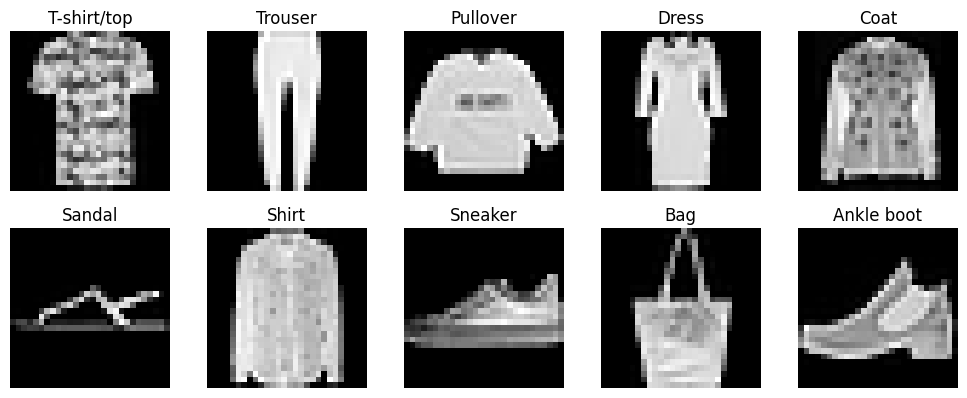

In [30]:
labels = train_data.iloc[:, 0].values    
images = train_data.iloc[:, 1:785].values  

class_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

def plot_images_from_all_classes(images, labels):
    plt.figure(figsize=(10, 10))
    
    for class_label in range(10):
        class_indices = [i for i in range(len(labels)) if labels[i] == class_label]
        
        if class_indices:
            index = class_indices[0]
            plt.subplot(5, 5, class_label + 1)  
            plt.imshow(images[index].reshape(28, 28), cmap='gray')  
            plt.title(class_names[class_label])  
            plt.axis('off')  
    
    plt.tight_layout()
    plt.show()

plot_images_from_all_classes(images, labels)

### Подготовка данных

Проверим данные на наличие пропусков.

In [33]:
print("Проверка на NaN в train data:")
print(train_data.isnull().sum().sum())
print("Проверка на NaN в test data:")
print(test_data.isnull().sum().sum())

Проверка на NaN в train data:
424
Проверка на NaN в test data:
0


Мы видим, что в train_data есть значения NaN. Заменим их на нули.

In [36]:
train_data = train_data.fillna(0)
print(train_data.isnull().sum().sum())

0


Преобразуем данные в numpy-массив, целевая переменная - первый столбец, фичи - все столбцы кроме первого и последнего. Далее нормализуем данные - приведем значение каждого пикселя в интервал от 0 до 1. Далее разделяем данные на обучающую и тестовую выборки и преобразуем метки классов в категориальный формат.

In [44]:
# Преобразование данных
X_train = train_data.iloc[:, 1:-1].values
y_train = train_data.iloc[:, 0].values

# Нормализация данных
X_train = X_train.reshape(-1, 28, 28, 1) / 255.0 

# Разделение на обучающую и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Преобразование меток в категориальный формат 
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

### Построение модели

In [46]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

C:\Users\user\anaconda3\envs\data_science_BETTER\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Проведем компиляцию и обучение модели.

In [51]:
# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6027 - loss: 1.1086 - val_accuracy: 0.8049 - val_loss: 0.5093
Epoch 2/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8022 - loss: 0.5471 - val_accuracy: 0.8442 - val_loss: 0.4217
Epoch 3/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8272 - loss: 0.4648 - val_accuracy: 0.8647 - val_loss: 0.3804
Epoch 4/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8487 - loss: 0.4114 - val_accuracy: 0.8627 - val_loss: 0.3722
Epoch 5/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8619 - loss: 0.3820 - val_accuracy: 0.8683 - val_loss: 0.3598
Epoch 6/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8667 - loss: 0.3565 - val_accuracy: 0.8841 - val_loss: 0.3404
Epoch 7/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8772 - loss: 0.3294 - val_accuracy: 0.8817 - val_loss: 0.3366
Epoch 8/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8861 - loss: 0.3058 - val_accuracy: 0.

In [53]:
val_loss, val_accuracy = model.evaluate(X_val, y_val) 
print(f'Validation accuracy: {val_accuracy:.4f}')

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8997 - loss: 0.4174
Validation accuracy: 0.8932


### Предсказание на тестовых данных

In [55]:
X_test = test_data.iloc[:, 1:785].values.astype('float32') / 255.0  
X_test = X_test.reshape(-1, 28, 28, 1)

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

print(predicted_classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[0 1 2 ... 8 8 1]


In [57]:
# Подготовка файла для отправки результатов
predicted_df = pd.DataFrame(data=predicted_classes,
                      columns=['label'])
predicted_df

,label
0,0
1,1
2,2
3,6
4,3
...,...
9995,0
9996,2
9997,8
9998,8


In [59]:
predicted_df.index.name = 'id'
predicted_df

,label
id,
0,0
1,1
2,2
3,6
4,3
...,...
9995,0
9996,2
9997,8


In [61]:
predicted_df.to_csv("submission30.csv", header='label', index=True)